In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt

pg.utils.units.quants['vel']['cMap'] = 'inferno_r'

Next, we build the crosshole acquisition geometry with two shallow boreholes.

In [2]:
# Acquisition parameters
bh_spacing = 20.0
bh_length = 25.0
sensor_spacing = 2

world = mt.createRectangle(start=[0, -(bh_length + 3)], end=[bh_spacing, 0.0],
                           marker=0)# the 4 corners of the rectangular if we consider everything on Y direction
# it seems like the points start from 0 then go to -28 then 20 to the right and finally goes back to 0

#depth = -np.arange(sensor_spacing, bh_length + sensor_spacing, sensor_spacing)#it is a negative value
depth = -np.arange(0.5, bh_length + 0.5, sensor_spacing)

sensors = np.zeros((len(depth) * 2, 2))  # two boreholes
sensors[len(depth):, 0] = bh_spacing  # x
sensors[:, 1] = np.hstack([depth] * 2)  # y

In [3]:
#x and y of the sensors
sensors

array([[  0. ,  -0.5],
       [  0. ,  -2.5],
       [  0. ,  -4.5],
       [  0. ,  -6.5],
       [  0. ,  -8.5],
       [  0. , -10.5],
       [  0. , -12.5],
       [  0. , -14.5],
       [  0. , -16.5],
       [  0. , -18.5],
       [  0. , -20.5],
       [  0. , -22.5],
       [  0. , -24.5],
       [ 20. ,  -0.5],
       [ 20. ,  -2.5],
       [ 20. ,  -4.5],
       [ 20. ,  -6.5],
       [ 20. ,  -8.5],
       [ 20. , -10.5],
       [ 20. , -12.5],
       [ 20. , -14.5],
       [ 20. , -16.5],
       [ 20. , -18.5],
       [ 20. , -20.5],
       [ 20. , -22.5],
       [ 20. , -24.5]])

Traveltime calculations work on **unstructured meshes and structured grids**. We demonstrate this here by simulating the synthetic data on an unstructured mesh and inverting it on a simple structured grid.

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x24bade0e730>)

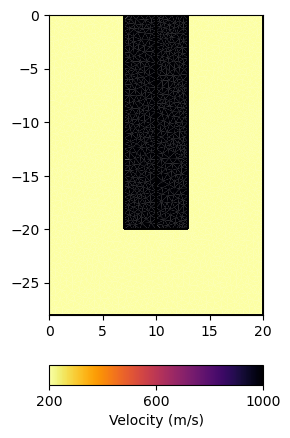

In [4]:
# Create forward model and mesh
c0 = mt.createRectangle(start=(7,0), end=(10,-20),marker=1)#width of 2#length of 20
c1 = mt.createRectangle(start=(10,0), end=(13,-20),marker=1)

#we are just combining whatever we defined
geom = world + c0 + c1

for sen in sensors:
    geom.createNode(sen)
    
#geom.addRegionMarker([10,-10],2)
mesh_fwd = mt.createMesh(geom, quality=34, area=0.25)
model = np.array([200, 1000])[mesh_fwd.cellMarkers()]

#marker can be 0, 1 or 2

pg.show(mesh_fwd, model,label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3, logScale=False)

Create Inversion Mesh

Mesh: Nodes: 588 Cells: 540 Boundaries: 1127


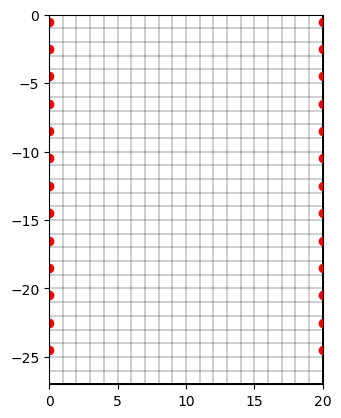

In [5]:
refinement = 0.5 #length of the elements
x = np.arange(0, bh_spacing + refinement, sensor_spacing * refinement)
y = -np.arange(0.0, bh_length + 3, sensor_spacing * refinement)
mesh = mt.createMesh2D(x, y)
ax, _ = pg.show(mesh, hold=True)
ax.plot(sensors[:, 0], sensors[:, 1], "ro")
print(mesh)

Next, we create an empty DataContainer and fill it with sensor positions and all possible shot-recevier pairs for the two-borehole scenario using the product function in the itertools module (Python standard library).

In [6]:
from itertools import product
numbers = np.arange(len(depth))

#product(a,b) in which a and b are the indices of each sensor
#output will be (x,y) for x in A for y in B
rays = list(product(numbers, numbers + len(numbers)))#it creates all the combinations of the S and R

# Empty container
scheme = pg.DataContainer()

# Add sensors
for sen in sensors:
    scheme.createSensor(sen)#create a sensor based on its location

# Add measurements
rays = np.array(rays)
scheme.resize(len(rays))#adding the data to sensors
scheme.add("s", rays[:,0])# s stands for source or shot--all the rows but just the first column
scheme.add("g", rays[:,1])# g stands for geophone
scheme.add("valid", np.ones(len(rays)))
scheme.registerSensorIndex("s")
scheme.registerSensorIndex("g")

The forward simulation is performed with a few lines of code. We initialize an instance of the Refraction manager and call its simulate function with the mesh, the scheme and the slowness model (1 / velocity). We also add 0.1% relative and 10 microseconds of absolute noise.

Secondary nodes allow for more accurate forward simulations. Check out the paper by Giroux & Larouche (2013) to learn more about it.

21/06/23 - 10:12:33 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
21/06/23 - 10:12:33 - pyGIMLi - WARNING - Mesh already contains secondary nodes. Not adding any more.


(<matplotlib.image.AxesImage at 0x24bae0bd2b0>,
 <matplotlib.colorbar.Colorbar at 0x24bcdae45b0>)

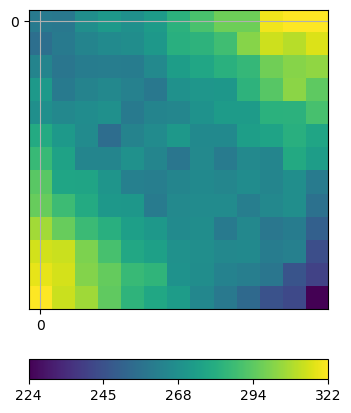

In [8]:
mesh_fwd.createSecondaryNodes(5)
data = tt.simulate(mesh=mesh_fwd, scheme=scheme, vel=model, noiseLevel=0, noiseAbs=0.001)
tt.showVA(data)

For the inversion we create a new instance of the Refraction manager to avoid confusion, since it is working on a different mesh.

In [19]:
mgr = tt.Manager(data)
# ttinv.setData(data)  # Set previously simulated data
mgr.setMesh(mesh, secNodes=3)
mgr.inv.setRegularization(correlationLengths=[5, 5])
invmodel = mgr.invert(lam=500, vTop=300, vBottom=300, verbose=True) #i am using a homogenous model
#lam stands for regularization parameter lambda and regulate the roughness (low values) or the smoothness in contrary. 
#zWeight is weighting of the horizontal regularization. With values lower than 1 you get more horizontal stuctures, with values
#greater 1 vertical structures are prefered. Best ist play with these parameters. Start with defaults and see how your 
#model change when you change the values. The target model should fit your data which can be seen with a chi² values 
#near to 1.

21/06/23 - 10:16:11 - pyGIMLi - INFO - Found 1 regions.
21/06/23 - 10:16:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/06/23 - 10:16:11 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
21/06/23 - 10:16:11 - pyGIMLi - INFO - Create gradient starting model. 300: 300
21/06/23 - 10:16:11 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333 0.00333333
 0

fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x0000024CACE66D60>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000024CACE66E00>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000024CACF3D400>
min/max (data): 0.07/0.1
min/max (error): 1.03%/1.35%
min/max (start model): 0.0033/0.0033
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 5.55 (dPhi = 87.01%) lam: 500
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 2.81 (dPhi = 41.63%) lam: 500.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.5 (dPhi = 22.61%) lam: 500.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.3 (dPhi = 4.49%) lam: 500.0
-----------------

Finally, we visualize the true model and the inversion result next to each other.

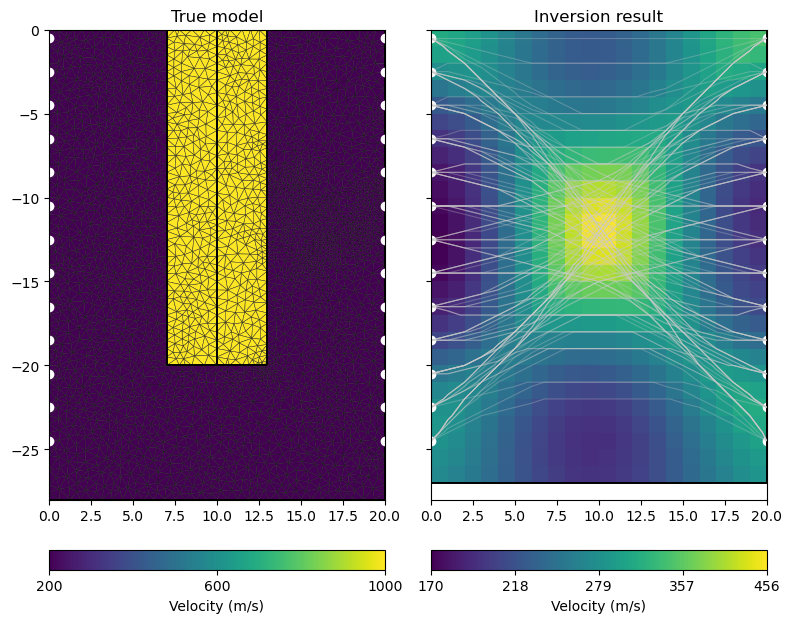

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7), sharex=True, sharey=True)
ax1.set_title("True model")
ax2.set_title("Inversion result")

pg.show(mesh_fwd, model, ax=ax1, showMesh=True, label="Velocity (m/s)",
        logScale=False, nLevs=3)

for ax in (ax1, ax2):
    ax.plot(sensors[:, 0], sensors[:, 1], "wo")

mgr.showResult(ax=ax2, cMap=plt.cm.viridis, cMin=200, cMax=1000)
mgr.showRayPaths(ax=ax2, color="0.8", alpha=0.3)
fig.tight_layout()

Note how the rays are attracted by the high velocity anomaly while circumventing the low velocity region. This is also reflected in the coverage, which can be visualized as follows:

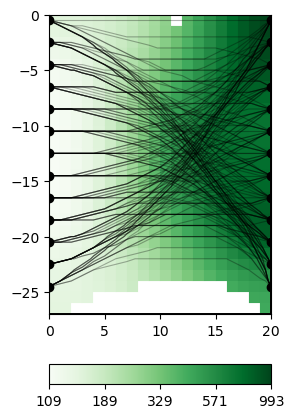

In [11]:
fig, ax = plt.subplots()
mgr.showCoverage(ax=ax, cMap="Greens")
mgr.showRayPaths(ax=ax, color="k", alpha=0.3)
ax.plot(sensors[:, 0], sensors[:, 1], "ko")


White regions indicate the model null space, i.e. cells that are not traversed by any ray.

### PYGIMLI uses EIKONAL equation to get the travel time instead of solving the whole wave eqaution

While the solution of the scalar wave equation represents the wavefield P(x, y, z; t) at a point in space (x, y, z) and at an instant of time t, the solution of the eikonal equation represents the traveltime T(x, y, z) for a ray passing through a point (x, y, z) in a medium with velocity v(x, y, z).

## Why do we need to add error to the numerical data??

The inversion theory demands a kind of data noise or data error .. in inversion we try to find a model with a best fit between simulated data and measured data weighted by the data error. ``model_fitting_error = ||(measured_data - simulated_data(model))/data_noise|| be minimal.`  i.e., "Find a model that explain our data in the limit of the data errors" so if you don't have a data error, the equation cannot be solved meaningful. Means, also in pure simulated environments you always need to noisify your data to make simulate inversion. Choosing the right amount of noise is crucial. With little noise you might get better inversion results but maybe got unrealstic expectations for real field data, also the numerical accuracy of the simulators plays a dominant role. With to much noise, you'll loose the information in the data and will get bad results. Thats why we recommand noise levels in the order of real measurements.